<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/main/Alexnet_grand_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim

In [2]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))

Number of image paths: 300
Number of labels: 300


In [3]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(degrees=[-15, 15]),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [4]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
num_epochs=5
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [7]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [8]:
net = torchvision.models.alexnet(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]


<generator object _BaseKFold.split at 0x7bd9a1c16ea0>
==========Cross Validation Fold 1==========
trainLoss: 0.6937 Acc: 0.5625
valLoss: 0.5660 Acc: 0.7667
trainLoss: 0.5503 Acc: 0.7500
valLoss: 0.5283 Acc: 0.7667
trainLoss: 0.5138 Acc: 0.7583
valLoss: 0.4943 Acc: 0.7667
trainLoss: 0.5316 Acc: 0.7500
valLoss: 0.4861 Acc: 0.7833
trainLoss: 0.5019 Acc: 0.7583
valLoss: 0.4670 Acc: 0.7833


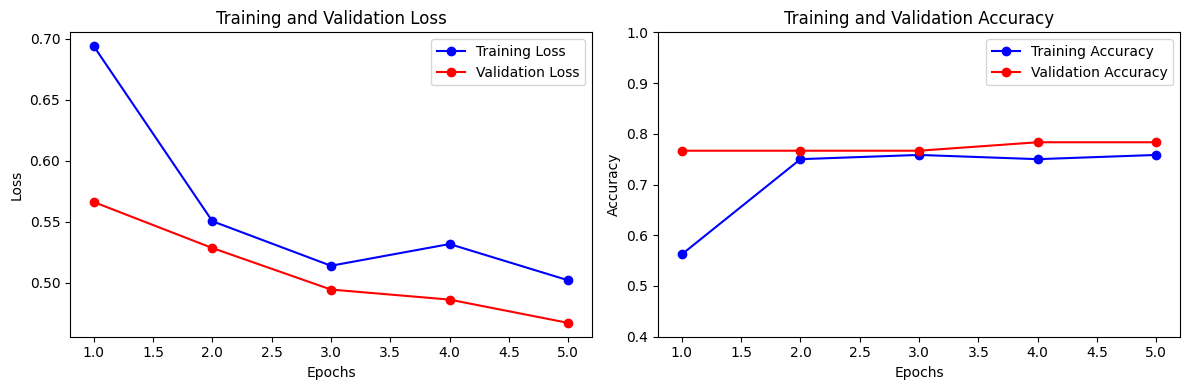

Train done.
Average Training Loss: 0.5582789750893911
Average Training Accuracy: 0.7158333333333333
Average Validation Loss: 0.508350133895874
Average Validation Accuracy: 0.7733333333333333
Train saved.
==========Cross Validation Fold 2==========
trainLoss: 0.6730 Acc: 0.6208
valLoss: 0.6418 Acc: 0.7167
trainLoss: 0.5903 Acc: 0.7542
valLoss: 0.6032 Acc: 0.7167
trainLoss: 0.5550 Acc: 0.7542
valLoss: 0.5718 Acc: 0.7167
trainLoss: 0.5387 Acc: 0.7625
valLoss: 0.5550 Acc: 0.7167
trainLoss: 0.5396 Acc: 0.7625
valLoss: 0.5390 Acc: 0.7333


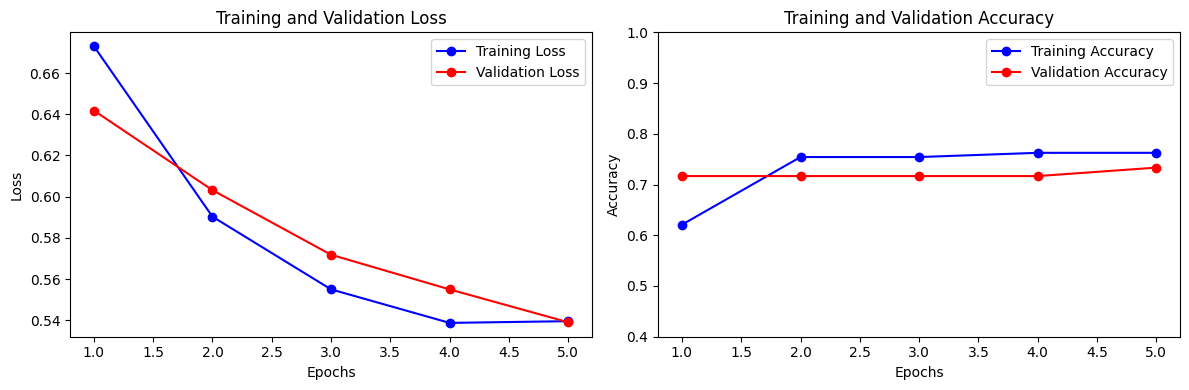

Train done.
Average Training Loss: 0.5793261520067852
Average Training Accuracy: 0.7308333333333333
Average Validation Loss: 0.5821585194269816
Average Validation Accuracy: 0.72
Train saved.
==========Cross Validation Fold 3==========
trainLoss: 0.5867 Acc: 0.7125
valLoss: 0.4922 Acc: 0.8000
trainLoss: 0.5568 Acc: 0.7500
valLoss: 0.4733 Acc: 0.7833
trainLoss: 0.5257 Acc: 0.7375
valLoss: 0.4662 Acc: 0.7833
trainLoss: 0.4981 Acc: 0.7667
valLoss: 0.4602 Acc: 0.8000
trainLoss: 0.4855 Acc: 0.7750
valLoss: 0.4586 Acc: 0.8000


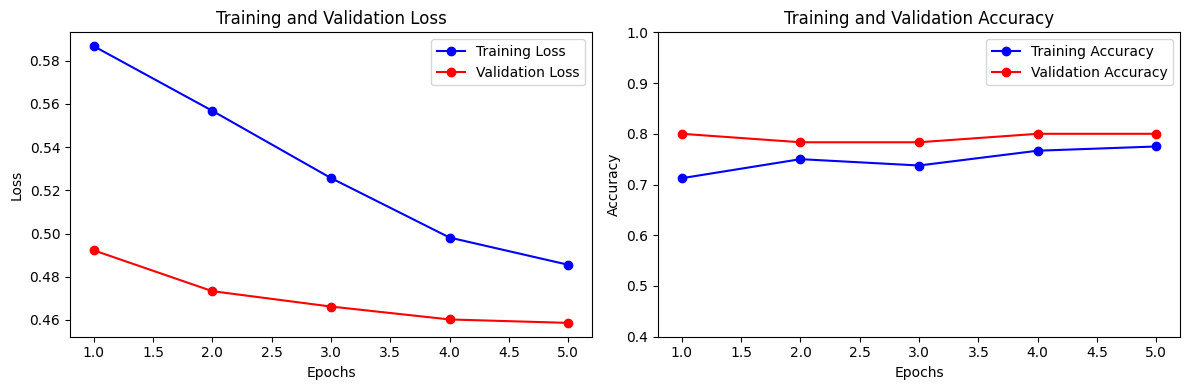

Train done.
Average Training Loss: 0.5305902417500814
Average Training Accuracy: 0.7483333333333333
Average Validation Loss: 0.4701248335838318
Average Validation Accuracy: 0.7933333333333333
Train saved.
==========Cross Validation Fold 4==========
trainLoss: 0.5809 Acc: 0.7375
valLoss: 0.5413 Acc: 0.7167
trainLoss: 0.5416 Acc: 0.7667
valLoss: 0.5304 Acc: 0.7333
trainLoss: 0.5118 Acc: 0.7667
valLoss: 0.5217 Acc: 0.7333
trainLoss: 0.5024 Acc: 0.7667
valLoss: 0.5059 Acc: 0.7333
trainLoss: 0.4847 Acc: 0.7917
valLoss: 0.5007 Acc: 0.7333


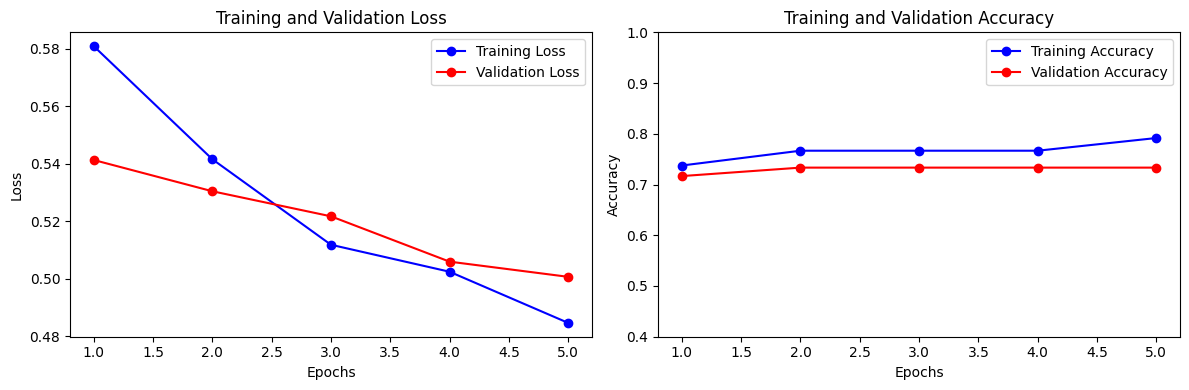

Train done.
Average Training Loss: 0.5242683712641398
Average Training Accuracy: 0.7658333333333334
Average Validation Loss: 0.5200070242087046
Average Validation Accuracy: 0.73
Train saved.
==========Cross Validation Fold 5==========
trainLoss: 0.6343 Acc: 0.6625
valLoss: 0.5364 Acc: 0.7667
trainLoss: 0.5136 Acc: 0.7792
valLoss: 0.5213 Acc: 0.7667
trainLoss: 0.4988 Acc: 0.7958
valLoss: 0.5181 Acc: 0.7833
trainLoss: 0.4910 Acc: 0.7958
valLoss: 0.5080 Acc: 0.7500
trainLoss: 0.4695 Acc: 0.8000
valLoss: 0.5100 Acc: 0.7833


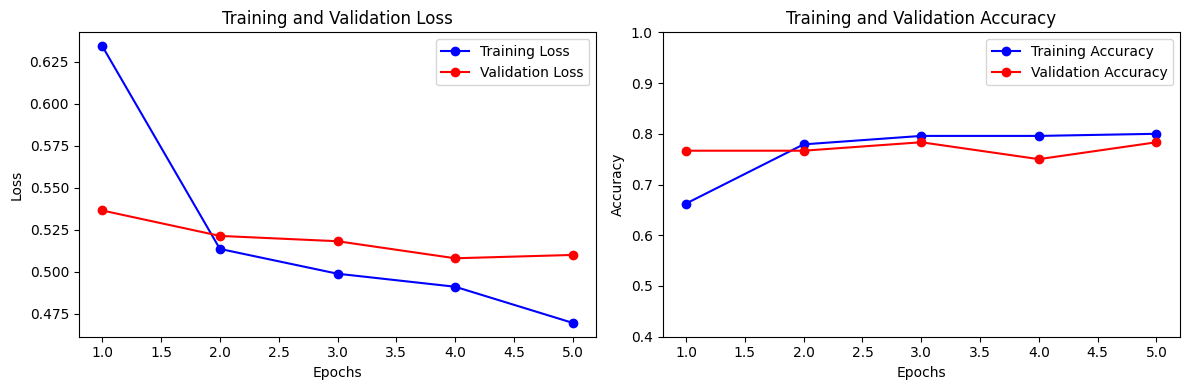

Train done.
Average Training Loss: 0.5214385203520457
Average Training Accuracy: 0.7666666666666666
Average Validation Loss: 0.5187707237402598
Average Validation Accuracy: 0.77
Train saved.


In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
print(kfold.split(image_paths))
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier[6] = nn.Linear(4096, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    # 全エポックの平均損失と平均精度を計算
    average_train_loss = sum(train_losses) / num_epochs
    average_train_acc = sum(train_accs) / num_epochs
    average_val_loss = sum(val_losses) / num_epochs
    average_val_acc = sum(val_accs) / num_epochs
    average_train_acc_cpu = average_train_acc.cpu().numpy()
    average_val_acc_cpu = average_val_acc.cpu().numpy()
    # 結果を表示
    print("Average Training Loss:", average_train_loss)
    print("Average Training Accuracy:", average_train_acc_cpu)
    print("Average Validation Loss:", average_val_loss)
    print("Average Validation Accuracy:", average_val_acc_cpu)
    total_train_accs.append(average_train_acc_cpu)
    total_val_accs.append(average_val_acc_cpu)
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')

In [19]:
print(sum(total_train_accs)/5)
print(sum(total_val_accs)/5)

0.7455
0.7573333333333333


In [ ]:
model.load_state_dict(torch.load(r'/content/drive/MyDrive/learning/weight/alexnet.pth'))
print('Train loaded.')